<a href="https://colab.research.google.com/github/Kryptera-K/GOOGL-KVO-MACD-Momentum-Sync-Strategy/blob/main/GOOGL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "GOOGL"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("GOOGL_clean.csv", index=False)
df

/tmp/ipython-input-663537637.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2004-08-19,2.493811,2.586266,2.384952,2.485361,893181924
2004-08-20,2.691894,2.711032,2.497788,2.510463,456686856
2004-08-23,2.718985,2.820388,2.710286,2.752538,365122512
2004-08-24,2.606397,2.773663,2.574088,2.764715,304946748
2004-08-25,2.634483,2.684190,2.581793,2.608635,183772044
...,...,...,...,...,...
2025-11-28,320.179993,326.850006,316.790009,323.369995,26018600
2025-12-01,314.890015,319.850006,313.890015,317.700012,41183000
2025-12-02,315.809998,318.380005,313.910004,316.739990,35854700


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

KVO_LEVEL = 0
KVO_LONG = 55
KVO_SHORT = 34
KVO_SIGNAL = 13
MACD_FAST = 12
MACD_LEVEL = 1.0
MACD_SIGNAL = 9
MACD_SLOW = 26

# -------------------------
# Indicator Functions
# -------------------------

def kvo_signal_is_below_level(df, level=KVO_LEVEL):
    df = klinger_volume_oscillator(df)
    return df['KVO_Signal'] < level


def klinger_volume_oscillator(df, short=KVO_SHORT, long=KVO_LONG, signal=KVO_SIGNAL):
    dm = df['High'] - df['Low']
    cm = np.cumsum(np.where(df['Close'] > df['Close'].shift(1), dm, -dm))
    vf = df['Volume'] * abs(2 * (df['Close'] - df['Low']) / (df['High'] - df['Low']) - 1)
    kvo = vf.ewm(span=short).mean() - vf.ewm(span=long).mean()
    df['KVO'] = kvo
    df['KVO_Signal'] = kvo.ewm(span=signal).mean()
    return df


def macd_cross_above_signal(df):
    df = calculate_macd(df)
    return (df["MACD_prev"] <= df["Signal_prev"]) & (df["MACD"] > df["Signal"])


def calculate_macd(df, fast=MACD_FAST, slow=MACD_SLOW, signal=MACD_SIGNAL):
    """
    Calculate MACD and Signal lines.
    """
    df = df.copy()
    df["EMA_fast"] = df["Close"].ewm(span=fast, adjust=False).mean()
    df["EMA_slow"] = df["Close"].ewm(span=slow, adjust=False).mean()
    df["MACD"] = df["EMA_fast"] - df["EMA_slow"]
    df["Signal"] = df["MACD"].ewm(span=signal, adjust=False).mean()

    # Previous values for comparisons
    df["MACD_prev"] = df["MACD"].shift(1)
    df["Signal_prev"] = df["Signal"].shift(1)

    return df



# -------------------------
# Entry conditions
# -------------------------

df["KVO_Signal_is_Below_Zero"] = kvo_signal_is_below_level(df)

# -------------------------
# Exit conditions
# -------------------------

df["MACD_cross_above_signal"] = macd_cross_above_signal(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'KVO_Signal_is_Below_Zero',
]
exit_conditions = [
    'MACD_cross_above_signal',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2004-08-19 00:00:00
End                                  2025-12-04 00:00:00
Period                                5359 days 00:00:00
Start Value                                     100000.0
End Value                                17881203.936979
Total Return [%]                            17781.203937
Benchmark Return [%]                        12863.912151
Max Gross Exposure [%]                             100.0
Total Fees Paid                            465916.611871
Max Drawdown [%]                               41.734839
Max Drawdown Duration                  597 days 00:00:00
Total Trades                                          55
Total Closed Trades                                   54
Total Open Trades                                      1
Open Trade PnL                            6682197.102856
Win Rate [%]                                   68.518519
Best Trade [%]                                 72.874254
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2004-08-19 00:00:00
End                           2025-12-04 00:00:00
Period                         5359 days 00:00:00
Start Value                              100000.0
End Value                         12963912.150595
Total Return [%]                     12863.912151
Benchmark Return [%]                 12863.912151
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        64.579763
Max Drawdown Duration          1229 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                    12863912.150595
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-1627425460.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


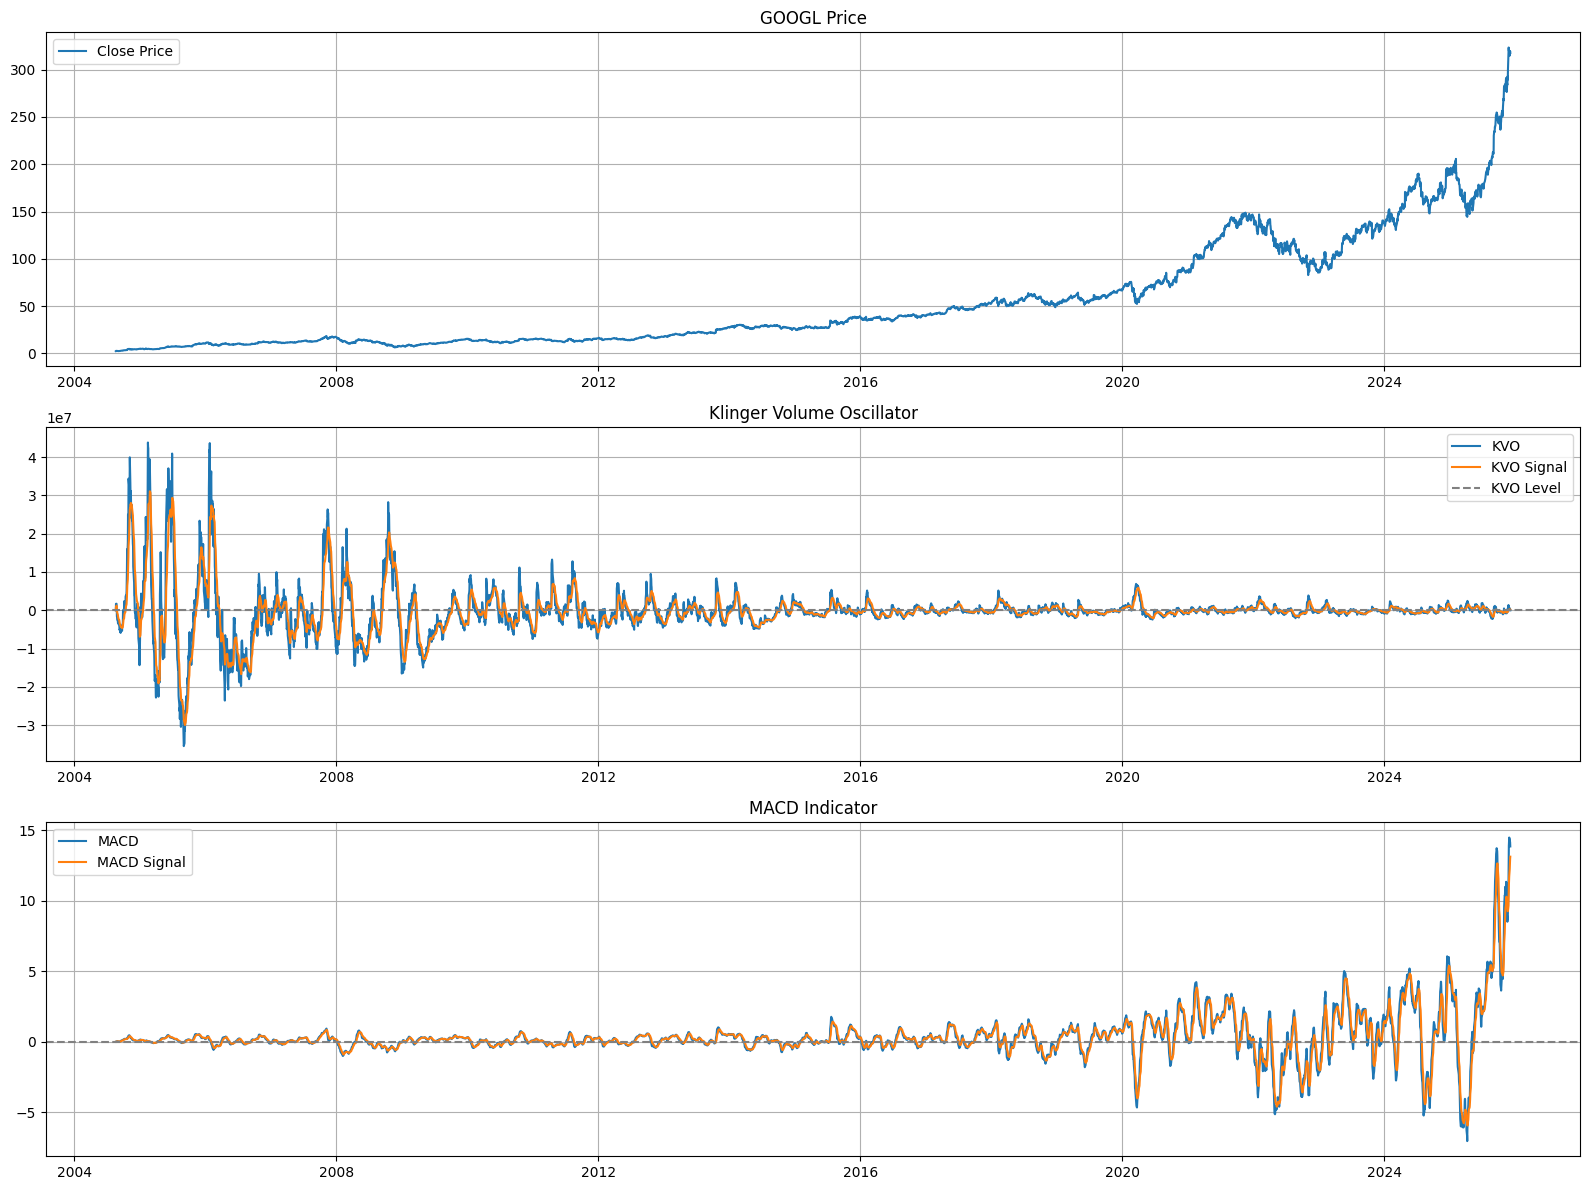

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------

symbol = "GOOGL"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Parameters
# -------------------------

KVO_LEVEL = 0
KVO_LONG = 55
KVO_SHORT = 34
KVO_SIGNAL = 13

MACD_FAST = 12
MACD_SLOW = 26
MACD_SIGNAL = 9

# -------------------------
# Indicator Functions
# -------------------------

def klinger_volume_oscillator(df, short=KVO_SHORT, long=KVO_LONG, signal=KVO_SIGNAL):
    dm = df['High'] - df['Low']
    cm = np.cumsum(np.where(df['Close'] > df['Close'].shift(1), dm, -dm))
    vf = df['Volume'] * abs(2 * (df['Close'] - df['Low']) / (df['High'] - df['Low']) - 1)

    kvo = vf.ewm(span=short).mean() - vf.ewm(span=long).mean()
    df['KVO'] = kvo
    df['KVO_Signal'] = kvo.ewm(span=signal).mean()

    return df


def calculate_macd(df, fast=MACD_FAST, slow=MACD_SLOW, signal=MACD_SIGNAL):
    df["EMA_fast"] = df["Close"].ewm(span=fast, adjust=False).mean()
    df["EMA_slow"] = df["Close"].ewm(span=slow, adjust=False).mean()

    df["MACD"] = df["EMA_fast"] - df["EMA_slow"]
    df["Signal"] = df["MACD"].ewm(span=signal, adjust=False).mean()

    return df


# -------------------------
# Calculate Indicators
# -------------------------

df = klinger_volume_oscillator(df)
df = calculate_macd(df)

# -------------------------
# Plotting
# -------------------------

plt.figure(figsize=(16, 12))

# --- Price Chart ---
ax1 = plt.subplot(3, 1, 1)
ax1.plot(df.index, df['Close'], label='Close Price')
ax1.set_title(f"{symbol} Price")
ax1.legend()
ax1.grid(True)

# --- KVO Chart ---
ax2 = plt.subplot(3, 1, 2)
ax2.plot(df.index, df['KVO'], label='KVO')
ax2.plot(df.index, df['KVO_Signal'], label='KVO Signal')
ax2.axhline(KVO_LEVEL, color='gray', linestyle='--', label='KVO Level')
ax2.set_title("Klinger Volume Oscillator")
ax2.legend()
ax2.grid(True)

# --- MACD Chart ---
ax3 = plt.subplot(3, 1, 3)
ax3.plot(df.index, df['MACD'], label='MACD')
ax3.plot(df.index, df['Signal'], label='MACD Signal')
ax3.axhline(0, color='gray', linestyle='--')
ax3.set_title("MACD Indicator")
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()
